# Importation of useful libraries

In [110]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET  # For XML parsing
import pyvista as pv  # For reading and processing mesh data
import pandas as pd  # For data manipulation and DataFrame creation
import plotly.graph_objs as go # For 3D interactive plot
from plotly.subplots import make_subplots # For 3D interactive plot
from scipy.ndimage import label # Function to count the number of clusters 
import plotly.express as px # Package to color each clusters different Path # To have an absolute path

print("Libraries imported successfully.")

Libraries imported successfully.


# Loading Averaged Data

In [111]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import pyvista as pv
import numpy as np

def load_data_and_average_velocity(directory):
    """
    This function loads CFD simulation data from PVTU files, averages the velocity components over time, and 
    converts the result into a Pandas DataFrame.
    
    Parameters:
    - directory (str): The path to the directory containing the PVD and PVTU files.
    
    Returns:
    - averaged_data (DataFrame): A DataFrame with columns for spatial coordinates (x, y, z) and 
      time-averaged velocity components (u, v, w).
    """
    
    # Parse the PVD file to extract mappings of timesteps to their corresponding PVTU files
    pvd_path = os.path.join(directory, 'channel.pvd')
    tree = ET.parse(pvd_path)
    root = tree.getroot()
    file_list = [
        os.path.join(directory, dataset.attrib['file'])
        for dataset in root.find('Collection')
    ]
    
    # Initialize arrays for accumulating data
    sum_u, sum_v, sum_w = None, None, None
    count = 0
    
    # Process each PVTU file
    for path in file_list:
        mesh = pv.read(path)  # Read the mesh data from the PVTU file
        if sum_u is None:
            # Initialize sum arrays with zeros having the same shape as the velocity components
            sum_u, sum_v, sum_w = mesh['VELOC'].T  # Transpose to separate the components
        else:
            # Accumulate the velocity components
            u, v, w = mesh['VELOC'].T
            sum_u += u
            sum_v += v
            sum_w += w
        
        count += 1
        print(f"Data from {path} loaded and velocity components added.")
    
    # Calculate the average of the velocity components
    avg_u = sum_u / count
    avg_v = sum_v / count
    avg_w = sum_w / count
    
    # Get the spatial coordinates (assuming they are the same for all files)
    points = mesh.points  # x, y, z coordinates
    
    # Create a DataFrame with the averaged data
    averaged_data = pd.DataFrame({
        'x': points[:, 0],
        'y': points[:, 1],
        'z': points[:, 2],
        'u': avg_u,
        'v': avg_v,
        'w': avg_w
    })
    
    print(f"Total data sets processed: {count}")
    return averaged_data


In [112]:
# Path to the directory containing the simulation files

directory_path = Path('/Users/corentinprados/Documents/Stage_M2/testALYA.nosync/Ancien/long_run/vtk')

# Load the data and store it in `data`
data = load_data_and_average_velocity(directory_path)

Data from /Users/corentinprados/Documents/Stage_M2/testALYA.nosync/Ancien/long_run/vtk/channel_00000000.pvtu loaded and velocity components added.
Data from /Users/corentinprados/Documents/Stage_M2/testALYA.nosync/Ancien/long_run/vtk/channel_00000300.pvtu loaded and velocity components added.
Data from /Users/corentinprados/Documents/Stage_M2/testALYA.nosync/Ancien/long_run/vtk/channel_00000600.pvtu loaded and velocity components added.
Data from /Users/corentinprados/Documents/Stage_M2/testALYA.nosync/Ancien/long_run/vtk/channel_00000900.pvtu loaded and velocity components added.
Data from /Users/corentinprados/Documents/Stage_M2/testALYA.nosync/Ancien/long_run/vtk/channel_00001200.pvtu loaded and velocity components added.
Data from /Users/corentinprados/Documents/Stage_M2/testALYA.nosync/Ancien/long_run/vtk/channel_00001500.pvtu loaded and velocity components added.
Data from /Users/corentinprados/Documents/Stage_M2/testALYA.nosync/Ancien/long_run/vtk/channel_00001800.pvtu loaded an

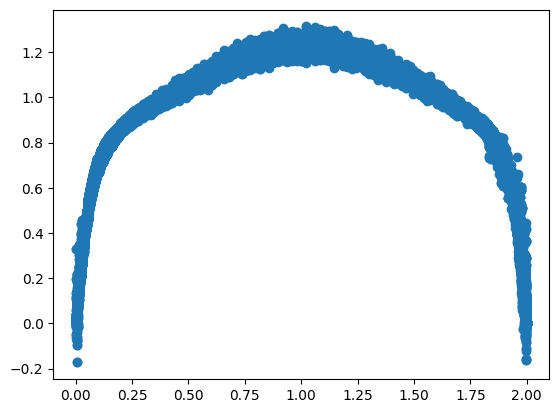

In [113]:
plt.scatter(data['y'],data['u'])

In [28]:
max(data['y'])

2.0

# Normalization

In [129]:
def normalize_data(averaged_data, nu):
    """
    Normalizes the velocity components and the coordinates (x, y, z) in the averaged_data DataFrame using:
    u_tau = (Omega_bar * nu) ** 0.5 and y^+ = y * u_tau / nu (similarly for x and z)
    
    Parameters:
    - averaged_data (DataFrame): DataFrame with columns for spatial coordinates (x, y, z) and
      time-averaged velocity components (u, v, w).
    - nu (float): Kinematic viscosity of the fluid.
    
    Returns:
    - averaged_data_normalized (DataFrame): DataFrame with the same columns as averaged_data,
      where the velocity components and coordinates (x, y, z) have been normalized.
    """
    # Group by the 'y' coordinate and compute the mean of the velocities u, v, w across x and z
    grouped = averaged_data.groupby('y').mean()
    u_y = grouped['u']
    y = grouped.index.values

    # Compute delta_u and delta_y at the minimum y (wall)
    delta_u_min = u_y.iloc[1] - u_y.iloc[0]
    delta_y_min = y[1] - y[0]
    Omega_bar_min = delta_u_min / delta_y_min

    # Compute delta_u and delta_y at the maximum y (wall)
    delta_u_max = u_y.iloc[-2] - u_y.iloc[-1]
    delta_y_max = y[-1] - y[-2]
    Omega_bar_max = delta_u_max / delta_y_max

    # Calculate u_tau at each wall and average them
    u_tau_min = (Omega_bar_min * nu) ** 0.5
    u_tau_max = (Omega_bar_max * nu) ** 0.5
    u_tau = (u_tau_min + u_tau_max) / 2
    print(f"Calculated u_tau: {u_tau}")

    # Normalize the velocity components
    averaged_data_normalized = averaged_data.copy()
    averaged_data_normalized['u'] /= u_tau
    averaged_data_normalized['v'] /= u_tau
    averaged_data_normalized['w'] /= u_tau

    # Normalize the coordinates 'x', 'y', 'z'
    averaged_data_normalized['x'] = averaged_data_normalized['x'] * u_tau / nu
    averaged_data_normalized['y'] = averaged_data_normalized['y'] * u_tau / nu
    averaged_data_normalized['z'] = averaged_data_normalized['z'] * u_tau / nu

    return averaged_data_normalized


In [130]:
nu = 0.0003546986585888876
normalized_data = normalize_data(data, nu)


Calculated u_tau: 0.05416718810813898


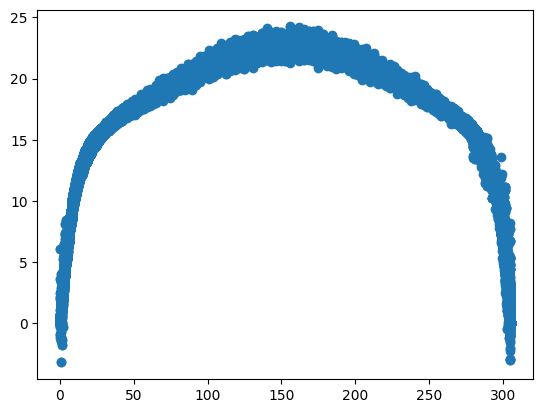

In [131]:
plt.scatter(normalized_data['y'], normalized_data['u'])

A faire :
- u fluctuation
- Ecire une fonction pour vérifer que Re = 180 